# Project Title: Fashion MNIST Classification using CNN

- **Student Name:** Hassan Ali Mehdi
- **Course:** Digital Image Processing  
- **Roll Number:** SU92-BSCSM-F23-211

## Abstract
This project aims to develop a Convolutional Neural Network (CNN) to classify images from the Fashion MNIST dataset. The dataset consists of 60,000 training images and 10,000 testing images of various clothing items. The goal is to achieve high classification accuracy by leveraging deep learning techniques.

## Objective
The primary objective is to implement a deep learning model that can accurately categorize fashion articles into one of 10 classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, and Ankle boot.

## 1. Setup and Imports
In this section, we import the necessary libraries for data manipulation, visualization, and model building. We utilize TensorFlow and Keras for constructing the CNN.

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import tensorflow as tf
import math
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds


## 2. Data Acquisition
The dataset is loaded from local CSV files if available, or downloaded using TensorFlow Datasets (TFDS) as a fallback. This ensures reproducibility and flexibility in data sourcing.

In [7]:
# Define class names manually as we might not have metadata from TFDS
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def load_data(data_dir='dataset'):
    train_path = os.path.join(data_dir, 'fashion-mnist_train.csv')
    test_path = os.path.join(data_dir, 'fashion-mnist_test.csv')

    if os.path.exists(train_path) and os.path.exists(test_path):
        print(f"Loading data from {data_dir}...")
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)

        def process_df(df):
            labels = df.iloc[:, 0].values
            images = df.iloc[:, 1:].values
            images = images.reshape(-1, 28, 28, 1)
            return tf.data.Dataset.from_tensor_slices((images, labels))

        train_dataset = process_df(train_df)
        test_dataset = process_df(test_df)

        # Mock metadata object for compatibility
        class Metadata:
            def __init__(self):
                self.features = {'label': type('obj', (object,), {'names': class_names})}
                self.splits = {
                    'train': type('obj', (object,), {'num_examples': len(train_df)}),
                    'test': type('obj', (object,), {'num_examples': len(test_df)})
                }
        metadata = Metadata()

        return train_dataset, test_dataset, metadata
    else:
        print("Local data not found, attempting to download with TFDS...")
        dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
        return dataset['train'], dataset['test'], metadata

train_dataset, test_dataset, metadata = load_data()

Loading data from dataset...


In [8]:
class_names=metadata.features['label'].names
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

## 3. Exploratory Data Analysis (EDA)
We examine the structure of the dataset, including the number of samples in the training and testing sets, and the distribution of classes.

### Dataset Statistics
The following output displays the count of examples in the training and testing splits, providing an overview of the data volume available for learning and evaluation.

In [9]:
num_train_examples=metadata.splits['train'].num_examples
num_test_examples=metadata.splits['test'].num_examples

print("Number of training examples : {}".format(num_train_examples))
print("number of testing examples : {}".format(num_test_examples))


Number of training examples : 60000
number of testing examples : 10000


## 4. Data Preprocessing
Preprocessing is a critical step in deep learning. We normalize the pixel values from the range [0, 255] to [0, 1] to facilitate faster convergence during training.

### Normalization Function
We define a function to cast image data to float32 and scale the values. This function is then mapped across the training and testing datasets.

In [10]:
def Normalize(images,labels):
    images=tf.cast(images,tf.float32)
    images/=255
    return images,labels


# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset=train_dataset.map(Normalize)
test_dataset=test_dataset.map(Normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster

train_dataset=train_dataset.cache()
test_dataset=test_dataset.cache()


### 4.1 Visualization of Preprocessed Data
Visualizing a sample image ensures that the preprocessing steps have been applied correctly and allows us to verify the integrity of the image data.

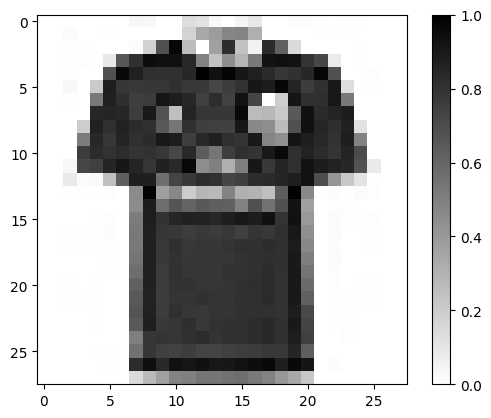

In [11]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
    break
image = image.numpy().reshape((28, 28))


plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()




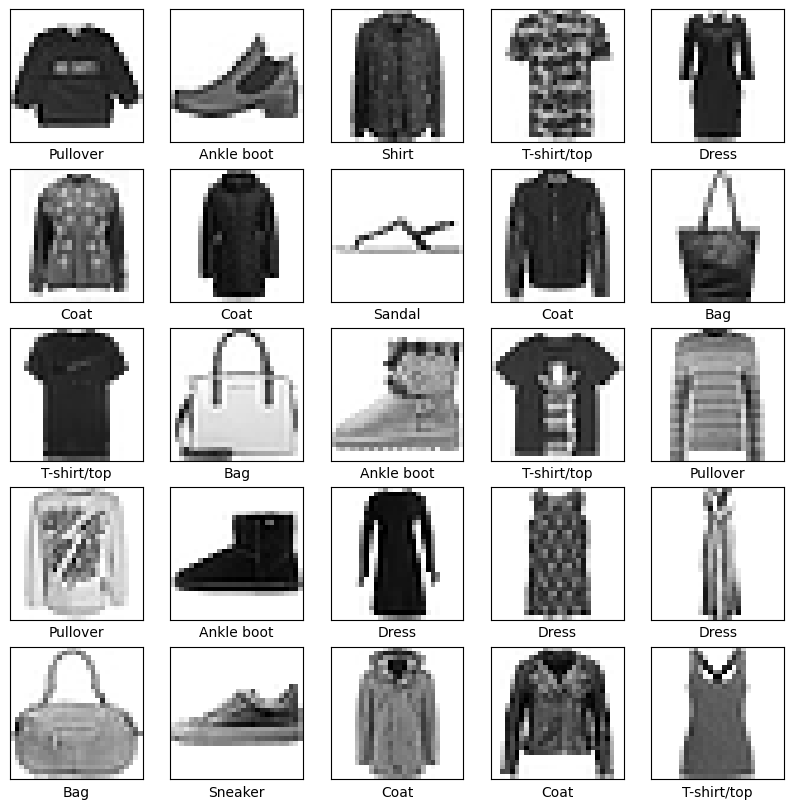

In [12]:
plt.figure(figsize=(10,10))
for i,(image,label) in enumerate(train_dataset.take(25)):
    image=image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image,cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()



## 5. Model Architecture
We construct a Sequential CNN model with the following layers:
- **Convolutional Layers**: To extract spatial features from the images.
- **MaxPooling Layers**: To reduce dimensionality and computation.
- **Flatten Layer**: To convert 2D feature maps into a 1D vector.
- **Dense Layers**: Fully connected layers for classification.

In [13]:
model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),padding='same',activation=tf.nn.relu,input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2),strides=2),
    tf.keras.layers.Conv2D(64,(3,3),padding='same',activation=tf.nn.relu,input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2),strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation=tf.nn.relu),
   tf.keras.layers.Dense(10,activation=tf.nn.softmax)
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 5.1 Model Compilation
The model is compiled using the Adam optimizer and Sparse Categorical Crossentropy loss function, which is suitable for multi-class classification problems.

In [14]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

## 6. Model Training
The model is trained on the training dataset for a specified number of epochs. We use batching and shuffling to ensure efficient and robust learning.

In [15]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [16]:
model.fit(train_dataset,epochs=20,steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.8026 - loss: 0.5453
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9001 - loss: 0.2768
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9168 - loss: 0.2299
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9303 - loss: 0.1893
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9386 - loss: 0.1699
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9494 - loss: 0.1355
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9567 - loss: 0.1164
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9631 - loss: 0.0992
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9686 - loss: 0.0824
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9758 - loss: 0.0655
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - accuracy: 0.9778 - loss: 0.0588
Epoch 12

## 6.1. Model Export
Save the trained CNN to disk for reuse or deployment.

In [36]:
import pathlib
export_dir = pathlib.Path('models')
export_dir.mkdir(parents=True, exist_ok=True)

model_path = export_dir / 'fashion_mnist_cnn.keras' # Changed to .keras
model.save(model_path)
print(f"Model saved to {model_path.resolve()}")

Model saved to /content/models/fashion_mnist_cnn.keras


In [37]:
import pathlib
export_dir = pathlib.Path('models')
export_dir.mkdir(parents=True, exist_ok=True)

model_path = export_dir / 'fashion_mnist_cnn.keras' # Changed to .keras
model.save(model_path)
print(f"Model saved to {model_path.resolve()}")

Model saved to /content/models/fashion_mnist_cnn.keras


## 7. Model Evaluation
After training, we evaluate the model's performance on the unseen test dataset to determine its generalization capability and accuracy.

In [38]:
test_loss,test_accuracy=model.evaluate(test_dataset,steps=math.ceil(num_test_examples/32))
print(f'The accuracy on test dataset is :{test_accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9155 - loss: 0.5523
The accuracy on test dataset is :0.9193999767303467


## 8. Prediction and Analysis
Finally, we use the trained model to make predictions on individual images from the test set. We visualize the predictions alongside the true labels and confidence scores to analyze the model's behavior.

In [39]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [40]:
predictions.shape

(32, 10)

In [41]:
predictions[0]

array([9.9999994e-01, 1.0761790e-24, 1.5394201e-19, 1.6756005e-20,
       8.5598456e-17, 4.9172540e-23, 3.0202696e-16, 4.3256593e-31,
       1.4100657e-21, 2.1447327e-24], dtype=float32)

In [42]:
np.argmax(predictions[0])

np.int64(0)

In [43]:
test_labels[0]

np.int64(0)

In [44]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

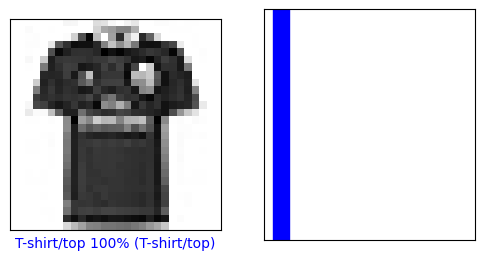

In [45]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

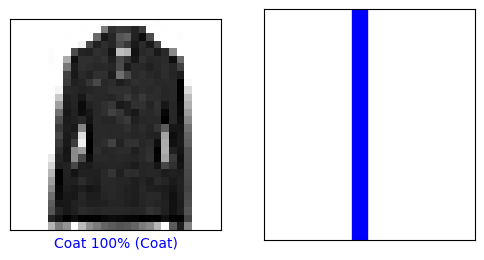

In [46]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

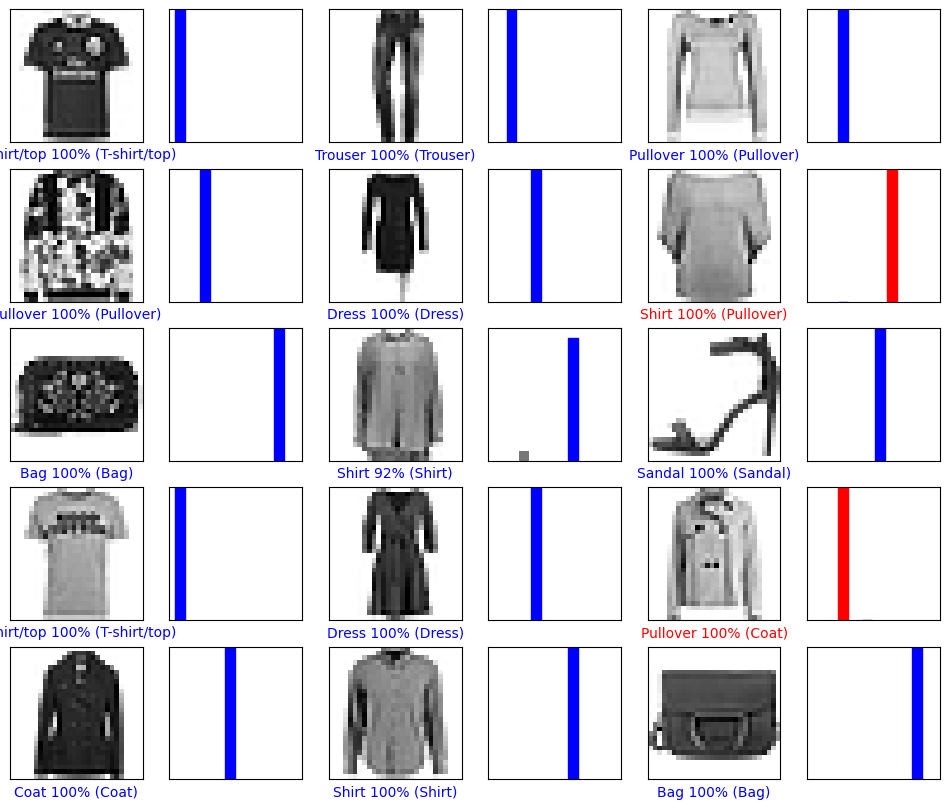

In [47]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


In [48]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [49]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


## 9. Model Evaluation with Metrics
Load the saved model and perform comprehensive evaluation including confusion matrix, classification report, and performance visualizations.

### 9.1 Import Required Libraries for Evaluation
Import additional libraries needed for metrics and visualization.

In [50]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

### 9.2 Load the Saved Model
Load the pre-trained CNN model from the models directory.

In [52]:
import tensorflow as tf

# Define custom objects to explicitly map internal activation names to TensorFlow functions
custom_objects = {
    'softmax_v2': tf.nn.softmax,
    'relu': tf.nn.relu
}

# Load the saved model with custom objects
loaded_model = tf.keras.models.load_model('models/fashion_mnist_cnn.keras', custom_objects=custom_objects)
print("Model loaded successfully!")
print("\nModel Summary:")
loaded_model.summary()

Model loaded successfully!

Model Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 843,286 (3.22 MB)

 Trainable params: 421,642 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 421,644 (1.61 MB)

### 9.3 Prepare Test Data for Evaluation
Collect all test images and labels for comprehensive evaluation.

In [53]:
# Collect all test images and labels
all_test_images = []
all_test_labels = []

for images, labels in test_dataset:
    all_test_images.append(images.numpy())
    all_test_labels.append(labels.numpy())

all_test_images = np.concatenate(all_test_images, axis=0)
all_test_labels = np.concatenate(all_test_labels, axis=0)

print(f"Total test images: {len(all_test_images)}")
print(f"Image shape: {all_test_images[0].shape}")

Total test images: 10000
Image shape: (28, 28, 1)


### 9.4 Generate Predictions
Use the loaded model to predict on the entire test dataset.

In [54]:
# Generate predictions for all test images
y_pred_probs = loaded_model.predict(all_test_images, batch_size=32, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = all_test_labels

print(f"\nPredictions shape: {y_pred.shape}")
print(f"True labels shape: {y_true.shape}")
print(f"\nSample predictions: {y_pred[:10]}")
print(f"Sample true labels: {y_true[:10]}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Predictions shape: (10000,)
True labels shape: (10000,)

Sample predictions: [0 1 2 2 3 6 8 6 5 0]
Sample true labels: [0 1 2 2 3 2 8 6 5 0]


### 9.5 Confusion Matrix Visualization
Create a detailed confusion matrix to visualize model performance across all classes.

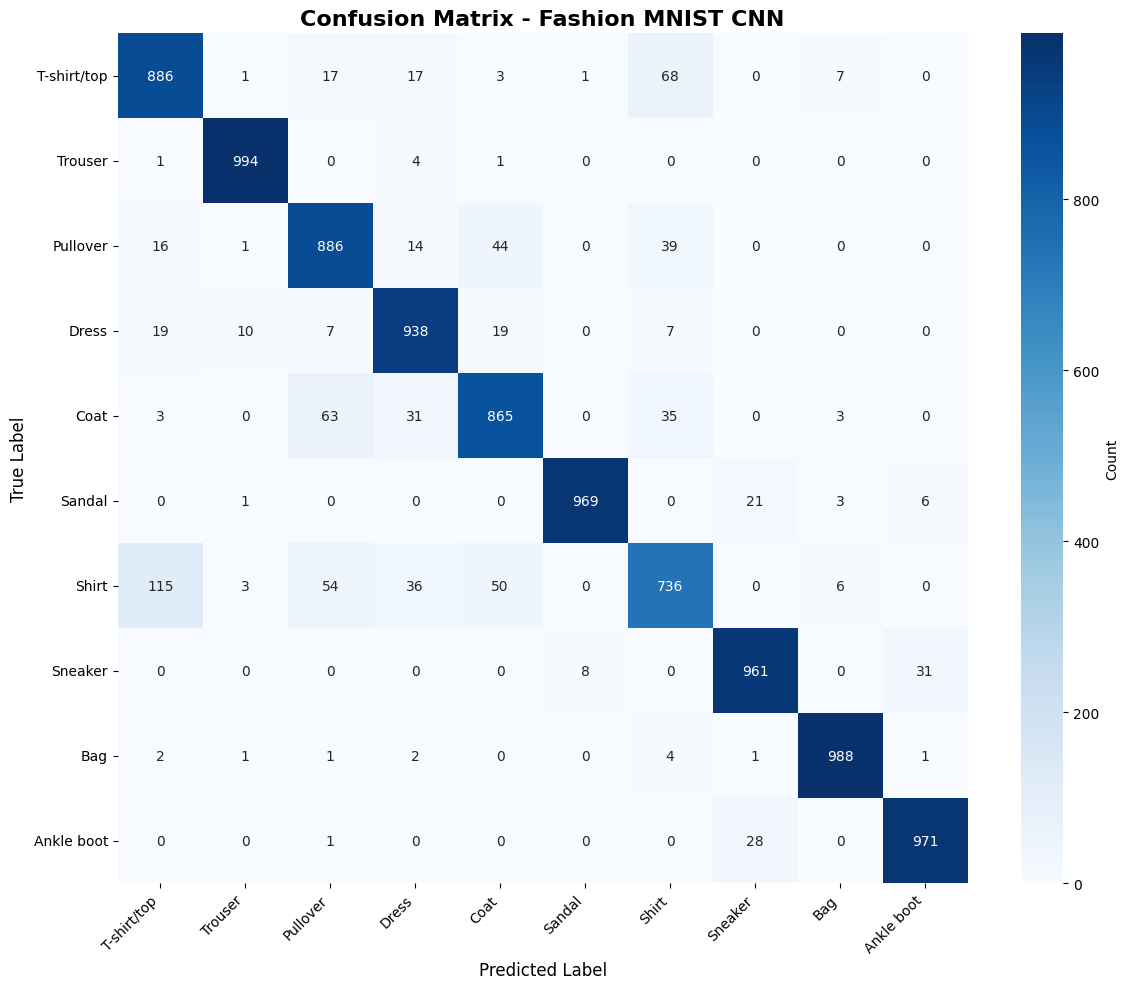


Confusion Matrix (Numerical):
[[886   1  17  17   3   1  68   0   7   0]
 [  1 994   0   4   1   0   0   0   0   0]
 [ 16   1 886  14  44   0  39   0   0   0]
 [ 19  10   7 938  19   0   7   0   0   0]
 [  3   0  63  31 865   0  35   0   3   0]
 [  0   1   0   0   0 969   0  21   3   6]
 [115   3  54  36  50   0 736   0   6   0]
 [  0   0   0   0   0   8   0 961   0  31]
 [  2   1   1   2   0   0   4   1 988   1]
 [  0   0   1   0   0   0   0  28   0 971]]


In [55]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix with seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Fashion MNIST CNN', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix (Numerical):")
print(cm)

### 9.6 Normalized Confusion Matrix
Display confusion matrix as percentages to better understand per-class accuracy.

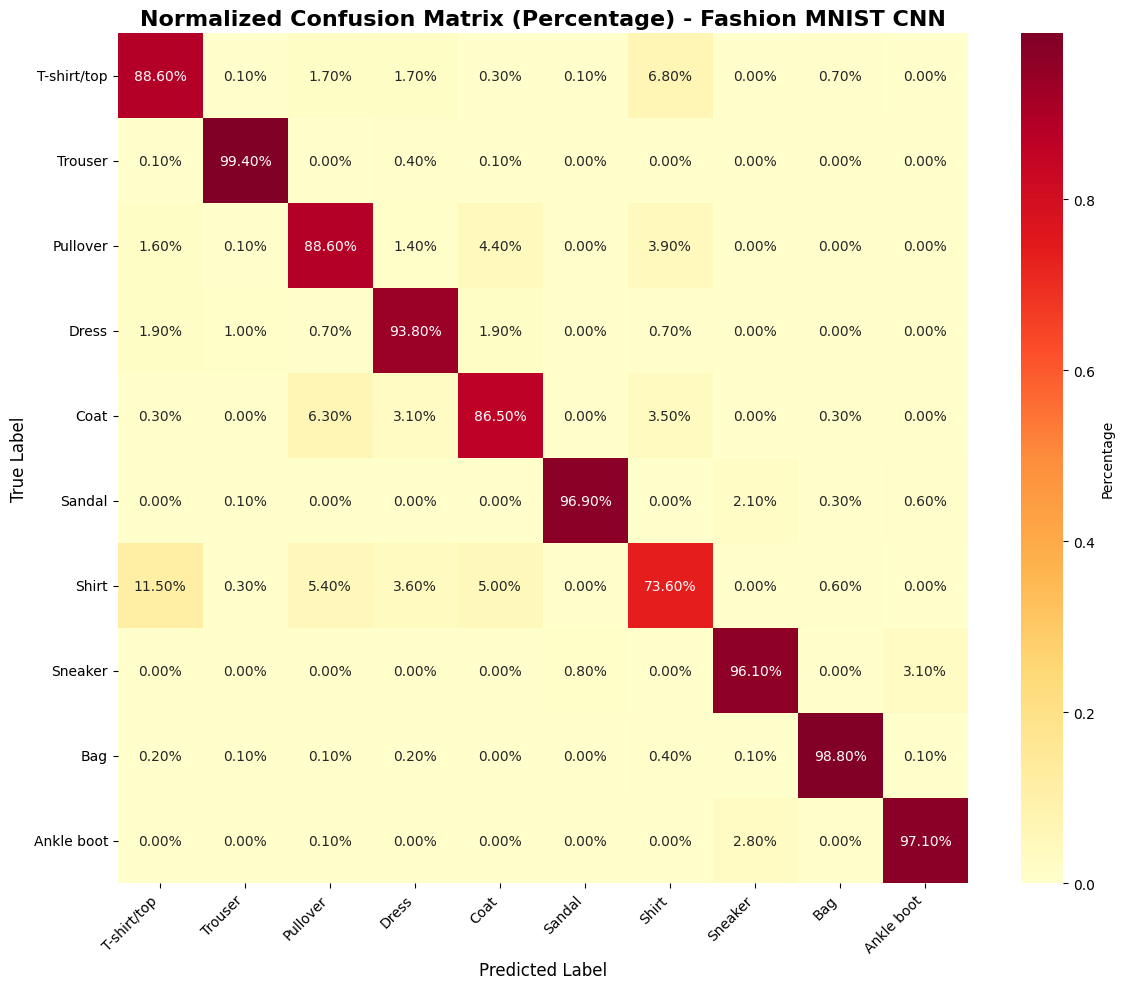

In [56]:
# Normalized confusion matrix (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='YlOrRd',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix (Percentage) - Fashion MNIST CNN',
          fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 9.7 Classification Report
Generate a detailed classification report with precision, recall, and F1-score for each class.

In [57]:
# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("="*70)
print("CLASSIFICATION REPORT - Fashion MNIST CNN")
print("="*70)
print(report)

# Also get the report as a dictionary for visualization
report_dict = classification_report(y_true, y_pred, target_names=class_names,
                                     output_dict=True, digits=4)
print("\nOverall Accuracy: {:.2%}".format(report_dict['accuracy']))

CLASSIFICATION REPORT - Fashion MNIST CNN
              precision    recall  f1-score   support

 T-shirt/top     0.8503    0.8860    0.8678      1000
     Trouser     0.9832    0.9940    0.9886      1000
    Pullover     0.8610    0.8860    0.8733      1000
       Dress     0.9002    0.9380    0.9187      1000
        Coat     0.8809    0.8650    0.8729      1000
      Sandal     0.9908    0.9690    0.9798      1000
       Shirt     0.8279    0.7360    0.7792      1000
     Sneaker     0.9505    0.9610    0.9557      1000
         Bag     0.9811    0.9880    0.9846      1000
  Ankle boot     0.9623    0.9710    0.9667      1000

    accuracy                         0.9194     10000
   macro avg     0.9188    0.9194    0.9187     10000
weighted avg     0.9188    0.9194    0.9187     10000


Overall Accuracy: 91.94%


### 9.8 Per-Class Performance Visualization
Visualize precision, recall, and F1-score for each class using bar charts.

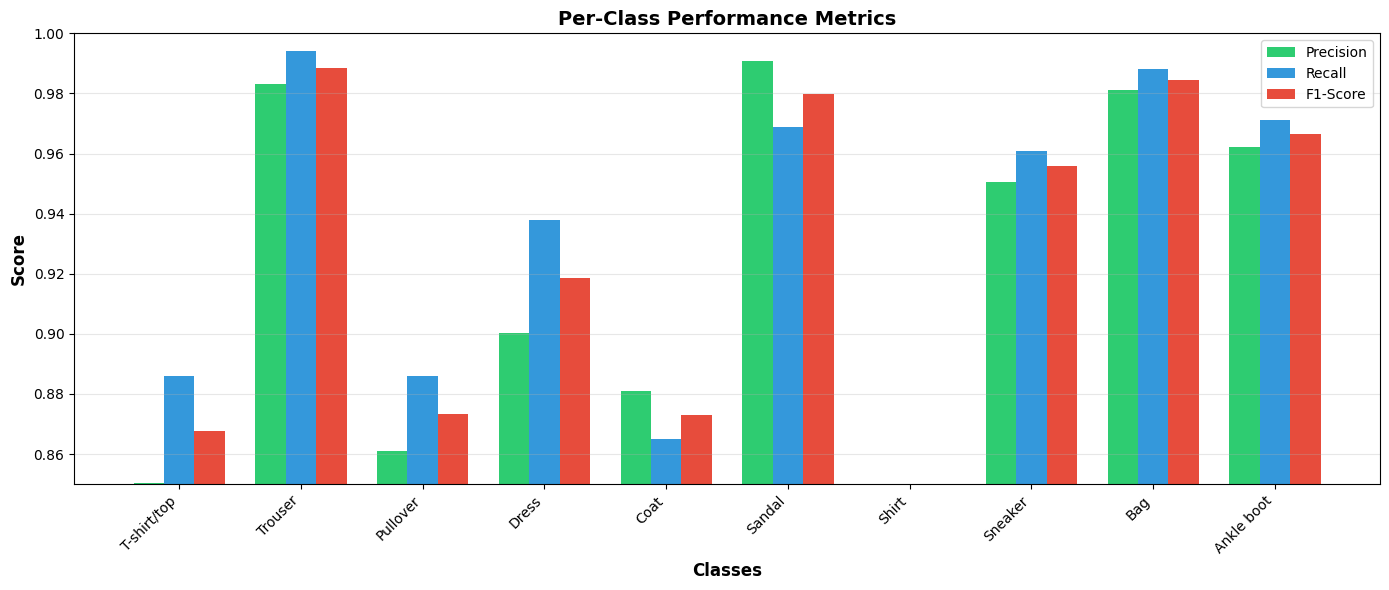

In [58]:
# Extract metrics for each class
classes = class_names
precision = [report_dict[cls]['precision'] for cls in classes]
recall = [report_dict[cls]['recall'] for cls in classes]
f1_score = [report_dict[cls]['f1-score'] for cls in classes]
support = [report_dict[cls]['support'] for cls in classes]

# Create bar chart
x = np.arange(len(classes))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 6))
bars1 = ax.bar(x - width, precision, width, label='Precision', color='#2ecc71')
bars2 = ax.bar(x, recall, width, label='Recall', color='#3498db')
bars3 = ax.bar(x + width, f1_score, width, label='F1-Score', color='#e74c3c')

ax.set_xlabel('Classes', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha='right')
ax.legend()
ax.set_ylim([0.85, 1.0])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 9.9 Class Distribution and Accuracy
Compare the distribution of test samples with per-class accuracy.

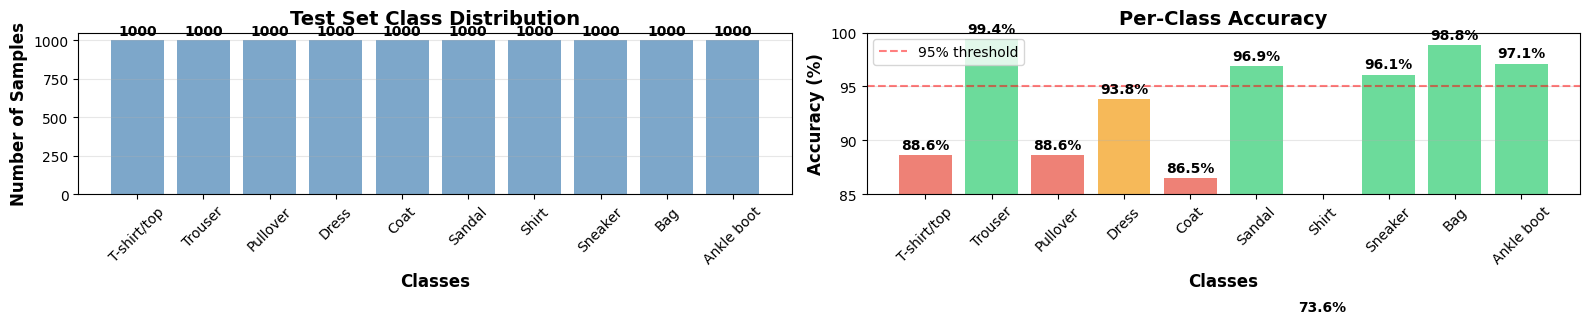


Per-Class Accuracy:
T-shirt/top    : 88.60%
Trouser        : 99.40%
Pullover       : 88.60%
Dress          : 93.80%
Coat           : 86.50%
Sandal         : 96.90%
Shirt          : 73.60%
Sneaker        : 96.10%
Bag            : 98.80%
Ankle boot     : 97.10%


In [59]:
# Calculate per-class accuracy from confusion matrix
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Sample distribution
ax1.bar(class_names, support, color='steelblue', alpha=0.7)
ax1.set_xlabel('Classes', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax1.set_title('Test Set Class Distribution', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(support):
    ax1.text(i, v + 10, str(int(v)), ha='center', va='bottom', fontweight='bold')

# Plot 2: Per-class accuracy
colors = ['#2ecc71' if acc >= 0.95 else '#f39c12' if acc >= 0.90 else '#e74c3c'
          for acc in per_class_accuracy]
ax2.bar(class_names, per_class_accuracy * 100, color=colors, alpha=0.7)
ax2.set_xlabel('Classes', fontsize=12, fontweight='bold')
ax2.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Per-Class Accuracy', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim([85, 100])
ax2.axhline(y=95, color='red', linestyle='--', alpha=0.5, label='95% threshold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(per_class_accuracy):
    ax2.text(i, v * 100 + 0.3, f'{v*100:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nPer-Class Accuracy:")
for cls, acc in zip(class_names, per_class_accuracy):
    print(f"{cls:15s}: {acc*100:.2f}%")

### 9.10 Error Analysis - Misclassified Examples
Visualize some misclassified examples to understand model weaknesses.

Total misclassified images: 806
Error rate: 8.06%


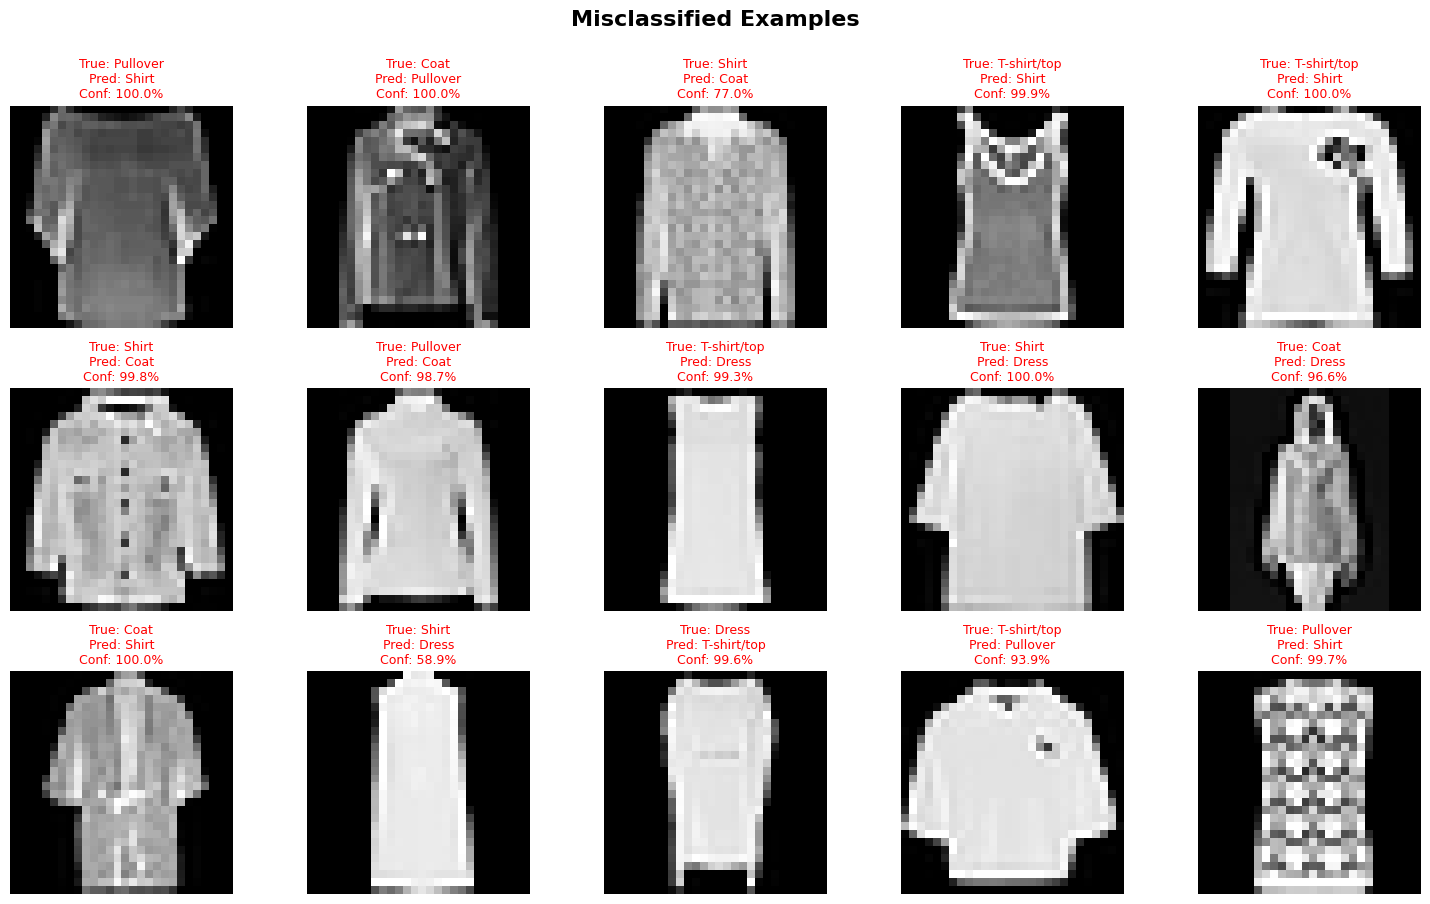

In [60]:
# Find misclassified examples
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"Total misclassified images: {len(misclassified_indices)}")
print(f"Error rate: {len(misclassified_indices) / len(y_true) * 100:.2f}%")

# Display 15 misclassified examples
num_examples = min(15, len(misclassified_indices))
plt.figure(figsize=(15, 9))

for i in range(num_examples):
    idx = misclassified_indices[i]

    plt.subplot(3, 5, i + 1)
    plt.imshow(all_test_images[idx].reshape(28, 28), cmap='gray')
    plt.axis('off')

    true_label = class_names[y_true[idx]]
    pred_label = class_names[y_pred[idx]]
    confidence = y_pred_probs[idx][y_pred[idx]] * 100

    title = f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%'
    plt.title(title, fontsize=9, color='red')

plt.suptitle('Misclassified Examples', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 9.11 Model Confidence Distribution
Analyze the distribution of prediction confidence scores.

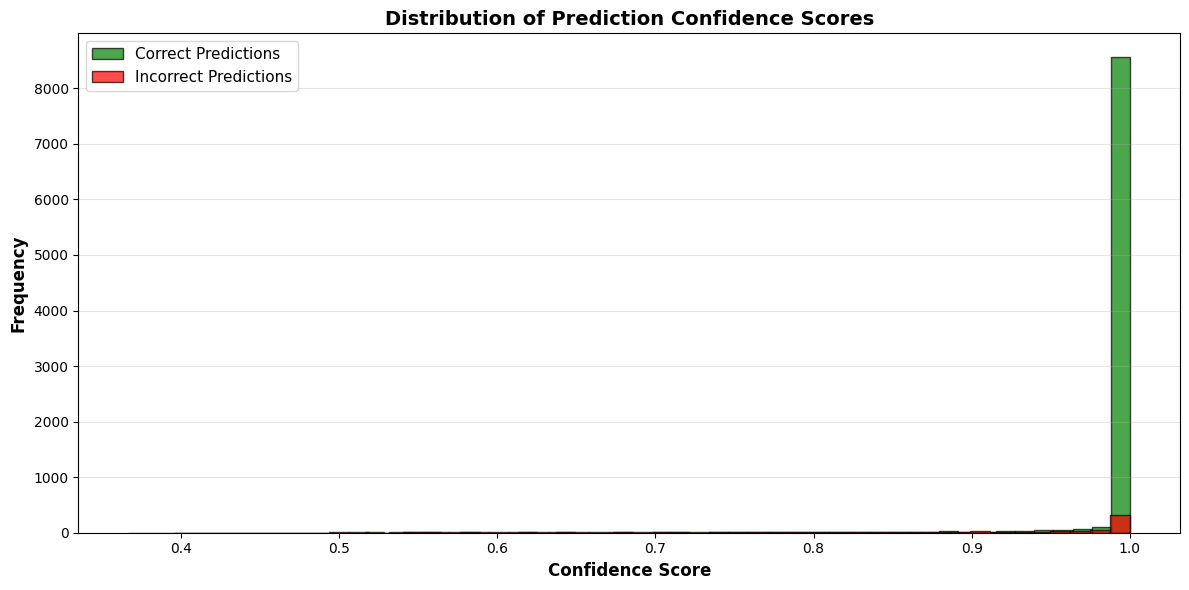


Correct Predictions:
  Mean confidence: 0.9898
  Median confidence: 1.0000
  Min confidence: 0.3954

Incorrect Predictions:
  Mean confidence: 0.8807
  Median confidence: 0.9642
  Max confidence: 1.0000


In [61]:
# Get confidence scores for all predictions
confidence_scores = np.max(y_pred_probs, axis=1)

# Separate confidence for correct and incorrect predictions
correct_mask = y_pred == y_true
correct_confidences = confidence_scores[correct_mask]
incorrect_confidences = confidence_scores[~correct_mask]

# Create histogram
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(correct_confidences, bins=50, alpha=0.7, label='Correct Predictions',
        color='green', edgecolor='black')
ax.hist(incorrect_confidences, bins=50, alpha=0.7, label='Incorrect Predictions',
        color='red', edgecolor='black')

ax.set_xlabel('Confidence Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Prediction Confidence Scores', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCorrect Predictions:")
print(f"  Mean confidence: {correct_confidences.mean():.4f}")
print(f"  Median confidence: {np.median(correct_confidences):.4f}")
print(f"  Min confidence: {correct_confidences.min():.4f}")

print(f"\nIncorrect Predictions:")
print(f"  Mean confidence: {incorrect_confidences.mean():.4f}")
print(f"  Median confidence: {np.median(incorrect_confidences):.4f}")
print(f"  Max confidence: {incorrect_confidences.max():.4f}")

### 9.12 Summary Statistics
Display comprehensive evaluation summary.

In [62]:
# Create comprehensive summary
print("="*70)
print(" " * 20 + "MODEL EVALUATION SUMMARY")
print("="*70)
print(f"\nDataset Information:")
print(f"  Total test samples: {len(y_true):,}")
print(f"  Number of classes: {len(class_names)}")

print(f"\nOverall Performance:")
print(f"  Accuracy: {report_dict['accuracy']*100:.2f}%")
print(f"  Macro Avg Precision: {report_dict['macro avg']['precision']*100:.2f}%")
print(f"  Macro Avg Recall: {report_dict['macro avg']['recall']*100:.2f}%")
print(f"  Macro Avg F1-Score: {report_dict['macro avg']['f1-score']*100:.2f}%")
print(f"  Weighted Avg F1-Score: {report_dict['weighted avg']['f1-score']*100:.2f}%")

print(f"\nPrediction Statistics:")
print(f"  Correct predictions: {np.sum(y_pred == y_true):,}")
print(f"  Incorrect predictions: {np.sum(y_pred != y_true):,}")
print(f"  Error rate: {(1 - report_dict['accuracy'])*100:.2f}%")

print(f"\nConfidence Analysis:")
print(f"  Average confidence (all): {confidence_scores.mean()*100:.2f}%")
print(f"  Average confidence (correct): {correct_confidences.mean()*100:.2f}%")
print(f"  Average confidence (incorrect): {incorrect_confidences.mean()*100:.2f}%")

# Best and worst performing classes
best_class_idx = np.argmax(per_class_accuracy)
worst_class_idx = np.argmin(per_class_accuracy)

print(f"\nBest Performing Class:")
print(f"  {class_names[best_class_idx]}: {per_class_accuracy[best_class_idx]*100:.2f}%")
print(f"\nWorst Performing Class:")
print(f"  {class_names[worst_class_idx]}: {per_class_accuracy[worst_class_idx]*100:.2f}%")

print("\n" + "="*70)

                    MODEL EVALUATION SUMMARY

Dataset Information:
  Total test samples: 10,000
  Number of classes: 10

Overall Performance:
  Accuracy: 91.94%
  Macro Avg Precision: 91.88%
  Macro Avg Recall: 91.94%
  Macro Avg F1-Score: 91.87%
  Weighted Avg F1-Score: 91.87%

Prediction Statistics:
  Correct predictions: 9,194
  Incorrect predictions: 806
  Error rate: 8.06%

Confidence Analysis:
  Average confidence (all): 98.10%
  Average confidence (correct): 98.98%
  Average confidence (incorrect): 88.07%

Best Performing Class:
  Trouser: 99.40%

Worst Performing Class:
  Shirt: 73.60%

